# Unsupervised Learning with Max-cut

This notebook is an example of unsupervised learning on a quantum computer. Both classical and quantum methods are used to classify the iris dataset.

## Outline
First, the classical k-means clustering algorithm is walked through. Second, the max-cut problem is mapped to an Ising Hamiltonian and solved using QAOA. This [kaggle tutorial](https://www.kaggle.com/efeergun96/unsupervised-learning-on-iris) on k-means, this [qiskit tutorial](https://github.com/qiskit-community/qiskit-qcgpu-provider/blob/master/examples/aqua/Max-Cut.ipynb) on max-cut, and the paper [*Unsupervised Machine Learning on a Hybrid Quantum Computer*](https://arxiv.org/abs/1712.05771) are helpful resources in constructing this notebook.

As usual, let's first import useful packages and take a peak at the data we'll be playing with.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

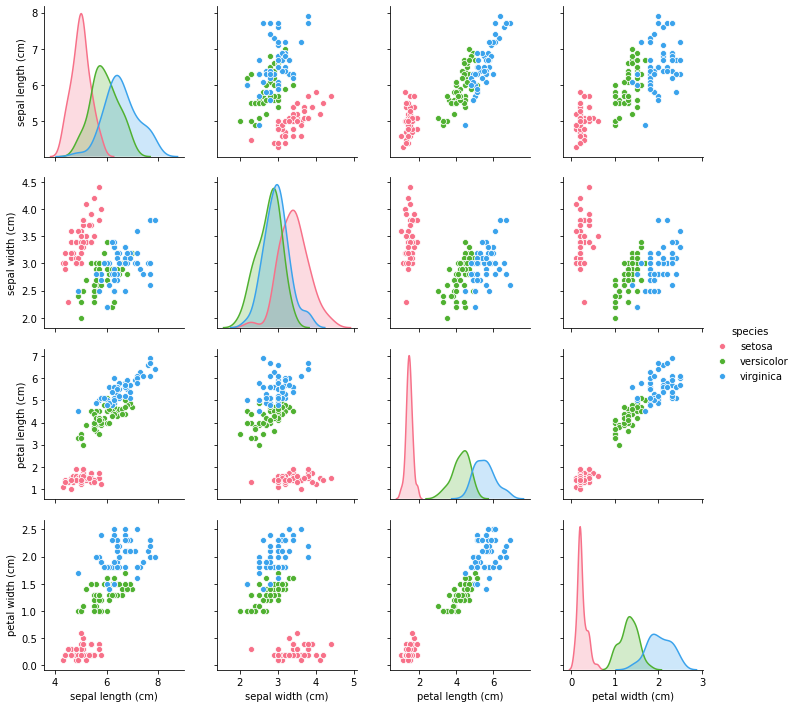

In [2]:
# Import Iris dataset
iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['species'] = pd.Categorical.from_codes(iris_data.target, iris_data.target_names)

# View data with known labels as a control to compare future clustering done by k-means and QAOA
sns.pairplot(data=df, hue="species", palette="husl")
plt.show()

Since the quantum computer will be simulated on laptops and not supercomputers, **let's reduce the dataset** from 150 entries to 12 for a resonable run time.

Though the details haven't been explained yet, max-cut can only split data into two clusters. More on that later. For now, we'll also need remove one of the species.

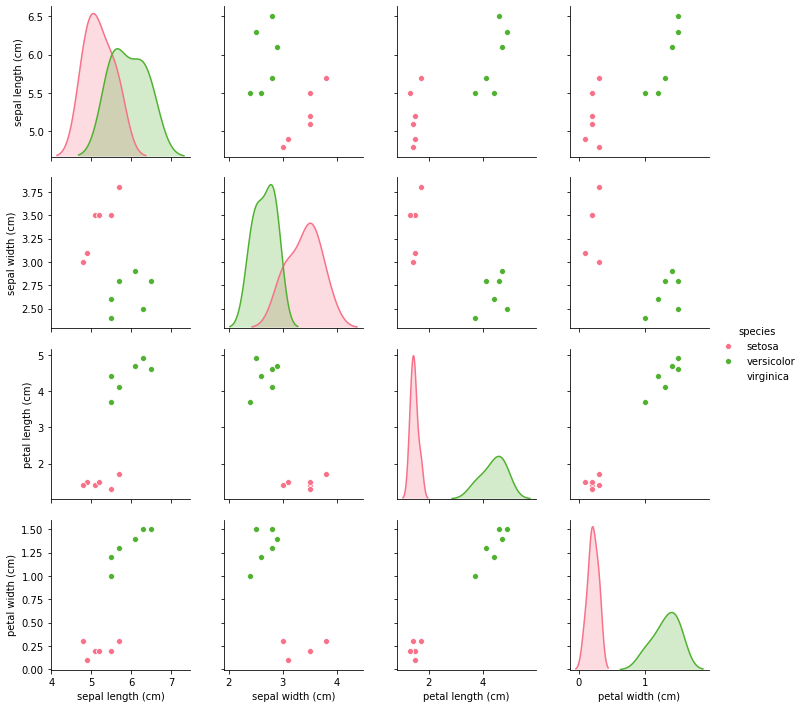

In [3]:
# Generate subset of data with fewer data points
df_sub = df.iloc[::9,:].reset_index(drop=True)

# Constrain data to only 2 species
df_sub = df_sub.loc[(df_sub['species'] == 'setosa') | (df_sub['species'] == 'versicolor')]

# View data with known labels as a control to compare future clustering done by k-means and QAOA
sns.pairplot(data=df_sub, hue="species", palette="husl")
plt.show()

## A Classical Approach
Let's use the unsupervised machine leanring algorithm k-means. K-means groups data into k clusters by minimizing each cluster's sum-of-sqaures also known as inertia

$$
\sum_{i=0}^{n} \min_{\mu_j \in C}(\lvert\lvert x_i - \mu_j\rvert\rvert^2)
$$

where $\mu_j$ is the mean of the jth cluster within the set $C$ of clusters.
(see scikit-learn's [clustering userguide](https://scikit-learn.org/stable/modules/clustering.html#k-means) for more details). The optimal number of clusters k is known for this data ($k=2$) since the reduced dataset only contains two species. However, let's pretend that's unknown as that would be the case for a real unsupervised learning application. Since we're pretending the optimal k is unknown, we can use the [elbow rule](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to find it.

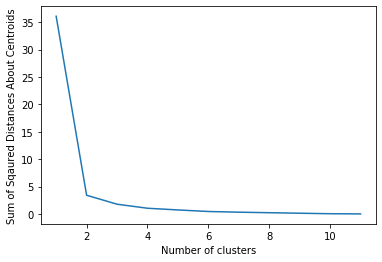

In [4]:
# Remove species labels (otherwise it's not unsupervised learning!)
df_sub_wo_labels = df_sub.loc[:,['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']]

# Use elbow rule to choose optimal k
dis = []
K = range(1,len(df_sub_wo_labels))
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_sub_wo_labels)
    dis.append(kmeans.inertia_)

# Visualize Optimal k
plt.plot(K, dis)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Sqaured Distances About Centroids')
plt.show()

Two is obviously the most elbowy and thus the optimal k. Let's fit and visualize the k-means algorithm with the optimal k.

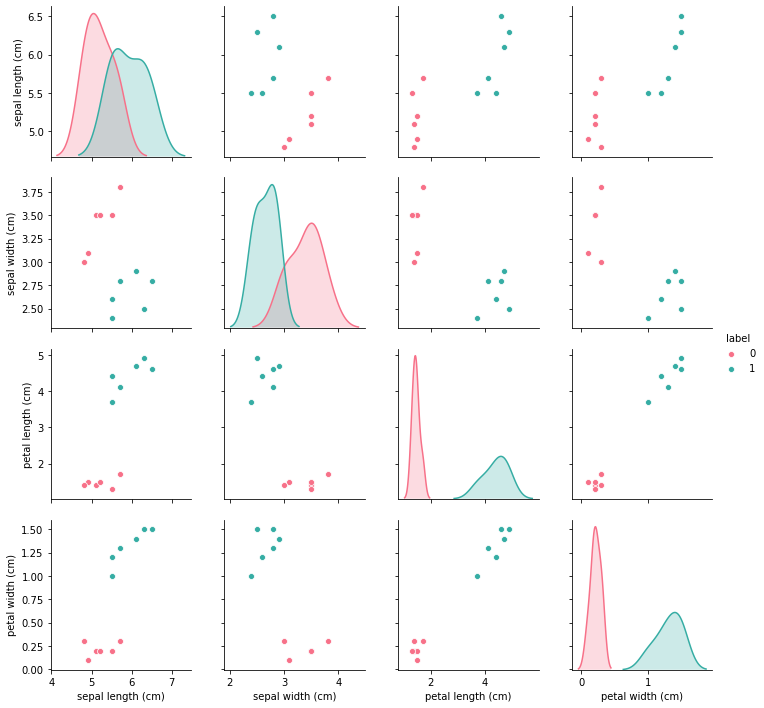

In [5]:
# Use optimal k for final k-means model
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(df_sub_wo_labels)

# Add k-means labeling to dataframe for later comparison
df_sub['label'] = kmeans.labels_

# Visualize clustering done by k-means algorithm
sns.pairplot(data=df_sub, hue='label', palette="husl", vars=df_sub.columns[:-2])
plt.show()

The plots looks identical to the original (reduced) dataset! Yay! With k = 2, the k-means algorithm clustering did a fantastic job on the iris dataset! The elbow rule really pulled through! Let's see how the quantum computer fares.

## A Quantum Approach

One approach to unsupervised quantum machine learning is to map the problem to a graph optimization problem (specifically max-cut in this notebook). The graph optimization problem can then be mapped to a cost Hamiltonian which can be efficiently solved by a quantum computer.

### Make a Graph

The first step in mapping data to a graph is calculating the pairwise "distances" between each data point. These distances will weight the edges of the graph. Let's use the $l^2\text{-norm}$ (i.e. vector magnitude). Remember, we're using a subset of the iris dataset to facilitate faster computation. 

In [6]:
# Get number of data entries
n_instances = len(df_sub_wo_labels)

# Convert dataframe into array
data_array = df_sub_wo_labels.values

# Calculate pairwise L2-norms
w = np.zeros((n_instances, n_instances))
for i in range(0,n_instances):
    for j in range(0,n_instances):
        w[i, j] = np.linalg.norm(data_array[i]-data_array[j])

print('Weight matrix size:',w.shape)

Weight matrix size: (12, 12)


### Map the Max-cut problem to a Cost Hamiltonian

To separate the graph into clusters, the graph is cut with a [max-cut](https://en.wikipedia.org/wiki/Maximum_cut): meaning the graph is separated in two while maximizing the total weight of the 'cut' edges. This is an NP-hard problem. However, it maps to an Ising model, which can be solved efficiently on a quantum computer.

We can interpret the output of the Ising model as follows. The spin variables $\hat{\sigma}_i^z \in \{-1, +1\}$ take on the value $\hat{\sigma}_i^z = +1$ for data in cluster 1, and $\hat{\sigma}_i^z = -1$ for data in cluster 2. The cost of one cut between nodes $i$ and $j$ is the edge's weight $w_{ij}$ that lies between them. In separating the graph into two sets of nodes ($S_1$ for cluster 1 and $S_2$ for cluster 2), the total weight of a cut $\delta(S)$ is

$$
w(\delta(S)) = \sum_{i\in S_1, j\in S_2} w_{ij}.
$$

Assuming a fully connected graph and accounting for the symmetry of $w_{ij}$ (i.e. $w_{ij} = w_{ji}$), the sum can be expanded to
$$
\begin{align}
w(\delta(S)) & = \frac{1}{2}\sum_{(ij) \in \delta(S_1)} w_{ij} \\
& = \frac{1}{4}\sum_{ij} w_{ij} - \frac{1}{4} \sum_{ij} w_{ij} \hat{\sigma}_i^z \hat{\sigma}_j^z \\
& = \frac{1}{4}\sum_{ij} w_{ij} (1- \hat{\sigma}_i^z \hat{\sigma}_j^z).
\end{align}
$$                 

By taking the negative of this, we can explicity see it's connection to the Ising Hamiltonian (external field $h = 0$ and constant $C$)

$$
H_{ising} = \sum_{ij}J_{ij}\hat{\sigma}_i^z\hat{\sigma}_j^z + C.
$$

Now that the max-cut is mapped to the Ising Hamiltonian, a quantum computer can efficiently find the max-cut by finding the ground state of $H_{ising}$. In fact, a quantum computer solving the max-cut problem in this way can (theoretically) out perform current classical algorithms. Though, it's been [proposed](https://www.nature.com/articles/s41598-019-43176-9) this won't be the case until there are quantum computers with hundreds of qubits. Side note: The Ising model conventionally written as a sum over all **nearest neighbor** pairs $\sum_{<ij>}$. Since the graph is fully connected (or can be made fully connected by adding edges of weight zero), $\sum_{<ij>}$ is identical to the double sum $\sum_{ij}$.

The ideas and derivation presented here can be found in the paper [*Unsupervised Machine Learning on a Hybrid Quantum Computer*](https://arxiv.org/abs/1712.05771).

### Solve the Max-cut Problem with QAOA

Now that the max-cut problem is mapped to an Ising Hamiltonian, the ground state needs to be found using a quantum algorithm. We will use [QAOA](https://arxiv.org/abs/1411.4028). QAOA is a quantum optimizer that will adiabatically find the ground state of a cost Hamiltonian--exactly what we need! Thankfully, Qiskit has a qaoa function all ready for us to use!

In [7]:
# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA

In [8]:
# QAOA hyperparameters and initialization
p = 1  # Number of adiabatic steps must be > 0
optimizer = COBYLA()  # Classical optimizer
qubit_ops, offset = max_cut.get_max_cut_qubitops(w)  # Compute qubit operations for QAOA algo
qaoa = QAOA(qubit_ops, optimizer, p)  # initialize QAOA algorithm

# Initialize quantum simulator
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1)

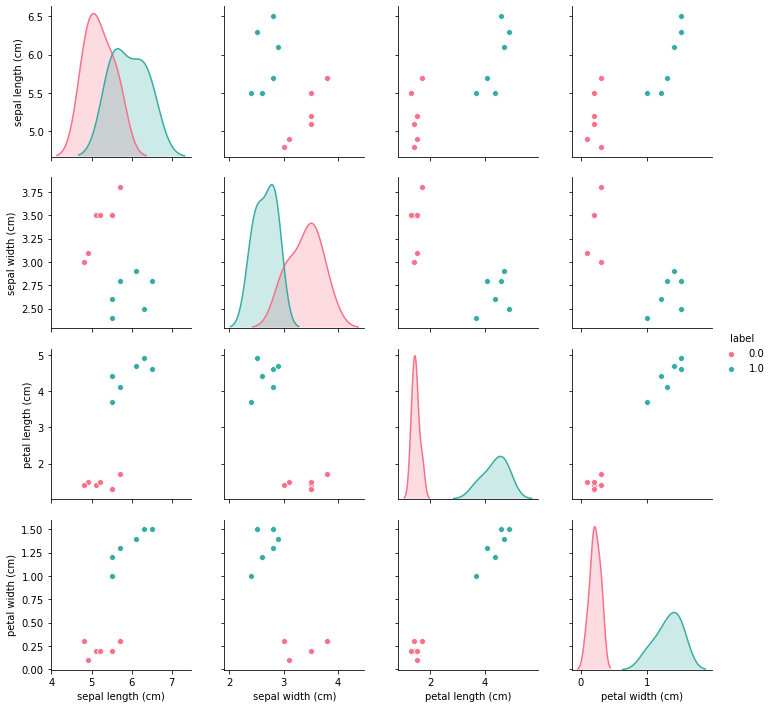

"Average" label classification:
species
setosa        0.0
versicolor    1.0
virginica     NaN
Name: label, dtype: float64


In [9]:
# Execute QAOA on quantum simulator
result = qaoa.run(quantum_instance)

# Extract clusters from result
x = max_cut.sample_most_likely(result['eigvecs'][0])

# Label clusters and include them in df_sub
labels = pd.DataFrame(max_cut.get_graph_solution(x), columns=['label'])
df_sub['label'] = labels

# Show data by cluster
sns.pairplot(data=df_sub,hue='label', palette="husl", vars=df_sub.columns[:-2])
plt.show()

# Display cluster label mean by species
print('\"Average\" label classification:')
print(df_sub.groupby(['species']).sum()['label'] / df_sub.groupby(['species']).count()['label'])

Since we know how the data is labeled by species before hand, we can compare this output to the species labeling. The plots look identical to the reduced dataset! All of setosa is in cluster 0, and all of versicolor is in cluster 1. For this simple example of solving max-cut with QAOA, the results look spectacular!

**What about the third species?** We ignored it here because max-cut only classifies the data into two clusters. Is there a way to use max-cut to give a 3 cluster classification? Or for that matter, any number of clusters? That would make for a much more useful unsupervised learning algorithm. Let's dicuss the answer in the [next notebook](https://github.com/ajrazander/Unsupervised-QML/blob/master/Max-cut_2%2B_divisive_clustering.ipynb).